In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torchvision import models
from torchvision.utils import save_image
import os
import tqdm
import PIL
import torch.nn.functional as F
import random
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
import math
from torchvision.models.feature_extraction import create_feature_extractor
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark =  True
torch.backends.cudnn.enabled =  True
torch.autograd.set_detect_anomaly(True)
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

cuda


In [2]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/home/aditya/Developer/repro/super_resolution/SRGAN.ipynb'
wandb.login()
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="srgan-trial",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "SRGAN",
    "dataset": "TinyDataset",
    "epochs": 2000,
    }
)

wandb: Currently logged in as: adigbhat. Use `wandb login --relogin` to force relogin


In [4]:
high_res_dim = 512
preprocess = transforms.Compose([
    transforms.Resize(high_res_dim),
    transforms.CenterCrop(high_res_dim),
    transforms.ToTensor(),
])
dataset = ImageFolder('/home/aditya/Datasets/flikr8k/', transform=preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

IndexError: index 4 is out of bounds for dimension 0 with size 4

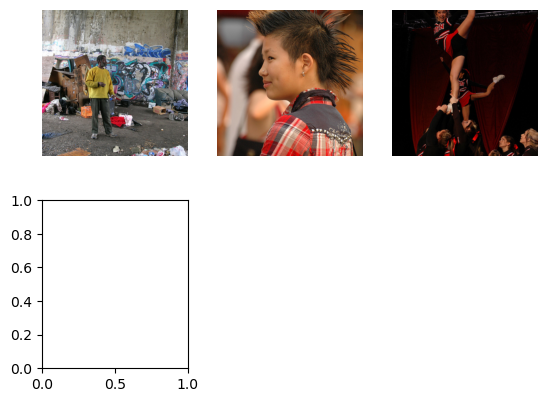

In [5]:
images, labels = next(iter(dataloader))
fig = plt.figure()
rows = 2
cols = 3
for ii in range(1, rows*cols + 1, 1):
    fig.add_subplot(rows, cols, ii)
    plt.imshow(images[ii].permute(1, 2, 0))
    plt.axis('off') 

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        x = self.layer1(x)
        x = torch.add(x, identity)
        return x

In [8]:
class _UpsampleBlock(nn.Module):
    def __init__(self, channels: int, upscale_factor: int) -> None:
        super(_UpsampleBlock, self).__init__()
        self.upsample_block = nn.Sequential(
            nn.Conv2d(channels, channels * upscale_factor * upscale_factor, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.PReLU(),
        )

    def forward(self, x):
        x = self.upsample_block(x)
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        channels = 64
        self.conv = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=9, stride=1, padding=4, bias=False)
        self.prelu = nn.PReLU()

        self.resblock1 = ResidualBlock(channels, channels)
        
        trunk = []
        for _ in range(16):
            trunk.append(ResidualBlock(channels, channels))
        self.resblock1 = nn.Sequential(*trunk)
            
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(64)
                                  )


        upscale = 4
        upsampling = []
        if upscale == 2 or upscale == 4 or upscale == 8:
            for _ in range(int(math.log(upscale, 2))):
                upsampling.append(_UpsampleBlock(channels, 2))
        else:
            raise NotImplementedError(f"Upscale factor `{upscale}` is not support.")
        self.upsampling = nn.Sequential(*upsampling)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)

        # Initialize neural network weights
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
        
    def forward(self, x):
        block1 = self.prelu(self.conv(x))
        
        block2 = self.resblock1(block1)
        block2 = self.conv2(block2)
        block2 = torch.add(block2, block1)

        block2 = self.upsampling(block2)
        block2 = self.conv4(block2)
        block2 = torch.clamp_(block2, 0.0, 1.0)
        return block2

In [10]:
class DiscriminatorConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DiscriminatorConvBlock, self).__init__()
        num_groups = 8
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False), 
                                   nn.GroupNorm(num_groups, out_channels),
                                   nn.LeakyReLU(0.2, True),
                                 )
    def forward(self, x):
        out = self.conv1(x)
        return out

In [11]:
class Discriminator(nn.Module):
    def __init__(self, low_res_dim):
        super(Discriminator, self).__init__()
        img_d = int(low_res_dim / 4)
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False), 
                                  nn.LeakyReLU(),
                                 )
        self.conv2 = DiscriminatorConvBlock(64, 64, 2)
        self.conv3 = DiscriminatorConvBlock(64, 128, 1)
        self.conv4 = DiscriminatorConvBlock(128, 128, 2)
        self.conv5 = DiscriminatorConvBlock(128, 256, 1)
        self.conv6 = DiscriminatorConvBlock(256, 256, 2)
        self.conv7 = DiscriminatorConvBlock(256, 512, 1)
        self.conv8 = DiscriminatorConvBlock(512, 512, 2)

        self.dense1 = nn.Linear(512 * img_d * img_d , 1024)
        self.leakyRelu = nn.LeakyReLU(0.2, False)
        self.dense2 = nn.Linear(1024 , 1)
        self.drop = nn.Dropout(0.3)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = out.view(-1, out.size(1) * out.size(2) * out.size(3))
        out = self.leakyRelu(self.dense1(out))
        out = torch.sigmoid(self.dense2(out))
        return out
        

In [ ]:
num_epochs = 2000
low_res = 128
gen_model = Generator().to(device)
disc_model = Discriminator(low_res).to(device)

# VGG terms
vgg = models.vgg19(pretrained=True).to(device)
feature_nodes = ["features.35"]
feature_extractor = create_feature_extractor(vgg, feature_nodes)
feature_extractor_nodes = feature_nodes
normalizeT = transforms.Normalize([ 0.5, 0.5, 0.5 ], [ 0.5, 0.5, 0.5 ])

for model_parameters in feature_extractor.parameters():
    model_parameters.requires_grad = False
feature_extractor.eval()

gen_optimizer = optim.Adam(gen_model.parameters(),lr=1e-4)
disc_optimizer = optim.Adam(disc_model.parameters(),lr=1e-4)
gen_scheduler = CosineAnnealingWarmRestarts(gen_optimizer, 
                                        T_0 = 8,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate
disc_scheduler = CosineAnnealingWarmRestarts(disc_optimizer, 
                                        T_0 = 8,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate
mse_loss = nn.MSELoss()
vgg_loss = nn.MSELoss()
disc_loss = nn.BCELoss()
disc_loss_generator = nn.BCELoss()
gen_optimizer.zero_grad()
for epoch in range(num_epochs):
    gen_scheduler.step()
    # disc_scheduler.step()
    for i, data in enumerate(tqdm.tqdm(dataloader)):
        input_images, labels = data
        # forward pass
        input_images = input_images.to(device)
        
        lowres_images = transforms.Resize(low_res)(input_images)
        gen_highres_images = gen_model(lowres_images.to(device))

        # Discriminator
        disc_model.zero_grad()
        actual_label = disc_model(input_images.to(device))
        # # Adversarial loss
        d2_loss = (disc_loss(actual_label, torch.ones_like(actual_label,dtype=torch.float)))
        d2_loss.backward()

        generated_label = disc_model(gen_highres_images.to(device))
        d1_loss = (disc_loss(generated_label, torch.zeros_like(generated_label,dtype=torch.float)))
        d1_loss.backward(retain_graph=True)

        errD = d2_loss + d1_loss
        disc_optimizer.step()

        gen_model.zero_grad() 
        # Perceptual loss
        mse = mse_loss(normalizeT(gen_highres_images), normalizeT(input_images))

        vgg_losses = []
        sr_feature = feature_extractor(normalizeT(input_images))
        gt_feature = feature_extractor(normalizeT(gen_highres_images))
        for i in range(len(feature_extractor_nodes)):
            vgg_losses.append(vgg_loss(sr_feature[feature_extractor_nodes[i]],
                                           gt_feature[feature_extractor_nodes[i]]))

        actual_generated_label = disc_model(gen_highres_images.to(device))
        gen_disc_loss = disc_loss_generator(actual_generated_label, torch.ones_like(actual_label,dtype=torch.float))
        generator_loss = vgg_losses[0] +  mse + gen_disc_loss
        generator_loss.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()
        torch.cuda.empty_cache()
        # dataloader.set_description("Epoch %d Generator Loss %f Memory %f GB / %f GB" % (epoch, generator_loss.mean(), torch.cuda.memory_allocated(0)/1024/1024/1024, torch.cuda.max_memory_reserved(0)/1024/1024/1024))
        wandb.log({"generator loss": generator_loss.mean(),
                   "mse": mse.mean(),
                   "vgg losses": vgg_losses[0].mean(),
                   "disc loss for generator": gen_disc_loss,
                  "disc loss while training": errD})
        # print("MSE loss: ", v_loss)
    # if epoch % 1 ==0:
    #     images, labels = next(iter(dataloader))
    #     fig = plt.figure()
    #     rows = 3
    #     cols = 2
    #     for ii in range(1, rows*cols + 1, 2):
    #         lowres_image = transforms.Resize(low_res)(images[ii])
    #         gen_highres_images = gen_model(torch.unsqueeze(lowres_image, 0).to(device))
            
    #         fig.add_subplot(rows, cols, ii)
    #         plt.imshow(images[ii].permute(1, 2, 0))
    #         plt.axis('off')
            
    #         fig.add_subplot(rows, cols, ii+1)
    #         hires = transforms.ToPILImage()
    #         plt.imshow(hires(gen_highres_images[0]))
    #         plt.axis('off') 
    if epoch % 5 == 0:
        checkpoint = {'model': Generator(),
              'input_size': 128,
              'output_size': 512,
              'state_dict': gen_model.state_dict()}
        torch.save(checkpoint,os.path.join("/home/aditya/Developer/repro/weights/","SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
wandb.finish()

/home/aditya/anaconda3/envs/dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aditya/anaconda3/envs/dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/aditya/anaconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/aditya/anaconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.i

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    return model

In [ ]:
gen_model = load_checkpoint("/home/aditya/Developer/repro/weights/SR136.pth").to(device)
low_res = 128
high_res = 512
topil = transforms.ToPILImage()
images, labels = next(iter(dataloader))
fig = plt.figure()
rows = 3
cols = 2
for ii in range(1, rows*cols + 1, 2):
    lowres_image = transforms.Resize(low_res)(images[ii])
    gen_highres_images = gen_model(torch.unsqueeze(lowres_image, 0).to(device))

    topil(lowres_image).save("input.jpg")
    
    fig.add_subplot(rows, cols, ii)
    plt.imshow(lowres_image.permute(1, 2, 0))
    topil(transforms.Resize(high_res)(lowres_image)).save("resized.jpg")
    plt.axis('off')
            
    fig.add_subplot(rows, cols, ii+1)
        
    topil(gen_highres_images[0]).save("generated.jpg")
    plt.imshow(topil(gen_highres_images[0]))
    plt.axis('off')